In [320]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [321]:
pd.set_option('display.max_columns', 50)

# Note that the total_data is out of order, it's participants 1 through 15, then participant 22, then participants
# 16 through 29 in the csv. 

total_data = pd.read_csv('total_participant_data.csv')

In [322]:
# drop the empty columns
total_data.drop(columns=['FixationFilter', 'CamLeftX', 'CamLeftY', 'CamRightX', 'CamRightY'], inplace=True)
total_data.drop(columns=['IRMarkerCount', 'IRMarkerID', 'PupilGlassesRight'], inplace=True)

# rename certain columns
total_data.rename(columns={'GazePointX (ADCSpx)': 'gen_gazeX', 'GazePointY (ADCSpx)': 'gen_gazeY'}, inplace=True)

In [323]:
# You can see that the recording names are all 'Rec 01', but for some reason P03 has the recording name 
# 'Participant_2', P14 has the recording name 'Rec 03', and P22 has the recording name 'Rec01'
# I think we can drop the RecordingName column

# total_data.groupby('ParticipantName').RecordingName.unique()
# total_data.RecordingName.unique()

# Drop the RecordingName column
total_data.drop(columns=['RecordingName'], inplace=True)

In [324]:
total_data

,ParticipantName,RecordingDate,MediaName,RecordingTimestamp,FixationIndex,GazeEventType,GazeEventDuration,gen_gazeX,gen_gazeY,GazePointLeftX (ADCSpx),GazePointLeftY (ADCSpx),GazePointRightX (ADCSpx),GazePointRightY (ADCSpx),FixationPointX (MCSpx),FixationPointY (MCSpx),GazePointX (MCSpx),GazePointY (MCSpx),DistanceLeft,DistanceRight,EyePosLeftX (ADCSmm),EyePosLeftY (ADCSmm),EyePosLeftZ (ADCSmm),EyePosRightX (ADCSmm),EyePosRightY (ADCSmm),EyePosRightZ (ADCSmm),ValidityLeft,ValidityRight,PupilLeft,PupilRight,SaccadeIndex
0,P01,11/4/2019,NaN,12.0,NaN,Unclassified,8.0,645.0,448.0,578.0,435.0,712.0,462.0,NaN,NaN,NaN,NaN,596.49,596.49,146.82,133.73,589.20,200.72,130.35,591.33,0.0,0.0,5.49,5.38,NaN
1,P01,11/4/2019,NaN,29.0,1.0,Fixation,733.0,644.0,452.0,579.0,437.0,710.0,467.0,NaN,NaN,NaN,NaN,596.52,596.52,146.81,133.75,589.23,200.71,130.36,591.30,0.0,0.0,5.49,5.38,NaN
2,P01,11/4/2019,NaN,46.0,1.0,Fixation,733.0,644.0,451.0,575.0,438.0,713.0,464.0,NaN,NaN,NaN,NaN,596.49,596.49,146.81,133.75,589.19,200.70,130.34,591.16,0.0,0.0,5.48,5.39,NaN
3,P01,11/4/2019,NaN,62.0,1.0,Fixation,733.0,646.0,451.0,579.0,440.0,713.0,463.0,NaN,NaN,NaN,NaN,596.42,596.42,146.82,133.73,589.12,200.70,130.32,591.12,0.0,0.0,5.49,5.38,NaN
4,P01,11/4/2019,NaN,79.0,1.0,Fixation,733.0,645.0,452.0,580.0,441.0,711.0,464.0,NaN,NaN,NaN,NaN,596.25,596.25,146.84,133.68,588.97,200.72,130.33,591.22,0.0,0.0,5.47,5.38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888472,P29,12/6/2019,NaN,730993.0,NaN,Saccade,50.0,907.0,95.0,881.0,83.0,933.0,108.0,NaN,NaN,NaN,NaN,652.29,652.29,145.54,148.64,642.97,206.17,152.90,642.30,0.0,0.0,4.33,3.97,2294.0
1888473,P29,12/6/2019,NaN,731010.0,NaN,Saccade,50.0,1132.0,43.0,1124.0,25.0,1141.0,62.0,NaN,NaN,NaN,NaN,652.68,652.68,146.06,148.76,643.35,206.63,153.07,642.97,0.0,0.0,4.30,3.97,2294.0
1888474,P29,12/6/2019,NaN,731026.0,NaN,Unclassified,25.0,1155.0,42.0,1153.0,26.0,1157.0,59.0,NaN,NaN,NaN,NaN,652.26,652.26,146.11,148.62,642.96,206.69,152.96,642.69,0.0,0.0,4.37,4.00,NaN
1888475,P29,12/6/2019,NaN,731043.0,NaN,Unclassified,25.0,1150.0,46.0,1153.0,31.0,1148.0,62.0,NaN,NaN,NaN,NaN,652.24,652.24,146.10,148.61,642.95,206.71,152.94,642.71,0.0,0.0,4.35,4.00,NaN


In [325]:
# Fix the mistakes in the ParticipantName column
def fix_participant_names(entry):
    if entry == 'P09':
        return 'P08'
    elif entry == 'P9':
        return 'P09'
    else:
        return entry

total_data.ParticipantName = total_data.ParticipantName.map(fix_participant_names)

In [326]:
# Replace the gen_gazeX and gen_gazeY entries for participant 12 with the left eye data because - due to participant
# 12's lazy right eye - the right eye calibration was way off

total_data.gen_gazeX = np.where(total_data.ParticipantName == 'P12', total_data['GazePointLeftX (ADCSpx)'], \
                                total_data.gen_gazeX)

total_data.gen_gazeY = np.where(total_data.ParticipantName == 'P12', total_data['GazePointLeftY (ADCSpx)'], \
                                total_data.gen_gazeY)

In [327]:
# change the media names to just be the order of the letters/numbers from middle left going clockwise
def change_media_name(media_name):
        # clever way to check for Nan (if Nan then keep it as Nan)
        if media_name != media_name:
            return media_name
        # if not Nan, then remove the '.tiff' and the 'anagram_' from the MediaName
        else:
            return media_name.rstrip('.tiff').lstrip('anagram_')

total_data.MediaName = total_data.MediaName.map(change_media_name)

In [328]:
# fix the exceptions in the MediaName entries
def fix_media_name_exceptions(media_name):
    if media_name == '5_anagram_12345':
        return '12345'
    elif media_name == '6_anagram_123456':
        return '123456'
    elif media_name == 'Black Screen.jpg':
        return 'black_break_image'
    else:
        return media_name

total_data.MediaName = total_data.MediaName.map(fix_media_name_exceptions)

In [329]:
# Show all the media names that were used. Note that the letters/numbers appeared from middle left going clockwise.
# This is explained later in this notebook. 

total_data.MediaName.unique()

array([nan, '123456', 'LEADFW', 'SCODLE', 'ARDIEM', 'IUJONR', 'RYEABT',
       'PNEUTA', 'MDTOSE', 'KUMEPA', 'ASONLG', 'OYSMTR', 'LMOARN',
       'AETCJK', 'AFDWLE', 'CEOLDS', 'IAMEDR', 'NOJUIR', 'ETABYR',
       'NAUPTE', 'ODTEMS', 'EUKMPA', 'GNSOAL', 'YSMOTR', 'MLRNAO',
       'EATCJK', 'WFEADL', 'CSOELD', 'RAIMED', 'JIUORN', 'YRBATE',
       'NPTAUE', 'OSMDTE', 'UAPEKM', 'NLASOG', 'RSOYMT', 'OMRLNA',
       'AEJKTC', 'LAEFDW', 'ELCSDO', 'DIEMAR', 'INOJRU', 'ATEYRB',
       'TNPUAE', 'OTEMDS', 'KPAEUM', 'NLAOSG', 'SRYTMO', 'LOMNAR',
       'AECJKT', '12345', 'CLHKA', 'ROEPW', 'BWRNO', 'TORCU',
       'black_break_image', 'DLEFAW', 'OESLDC', 'DEMIAR', 'IRNOJU',
       'EATYBR', 'UPTANE', 'MSOTED', 'EMKPUA', 'OGSALN', 'OYTRSM',
       'MONARL', 'CETAKJ', 'HKCAL', 'WRPEO', 'WRNOB', 'ROTCU', 'LDFAEW',
       'EODLSC', 'IMEARD', 'NOUJIR', 'ABRYET', 'NAPUET', 'MSOTDE',
       'UAEMKP', 'LCAKH', 'ORWPE', 'ONRWB', 'ORUCT', 'AELDWF', 'LSODCE',
       'EAIMRD', 'JONURI', 'TBREYA', 'TENUAP', 'D

ParticipantName
P19    3.442020
P16    1.766279
P15    0.719301
P03    0.615534
P26    0.601106
P14    0.478443
P23    0.459192
P13    0.443917
P09    0.393745
P01    0.352290
P07    0.347745
P22    0.303804
P10    0.298931
P25    0.298650
P29    0.293147
P17    0.227329
P02    0.226550
P20    0.223222
P11    0.203371
P28    0.201545
P06    0.175465
P27    0.157493
P12    0.147500
P08    0.144723
P21    0.132226
P24    0.126541
P05    0.116933
P18    0.106925
P04    0.097689
Name: ValidityLeft, dtype: float64

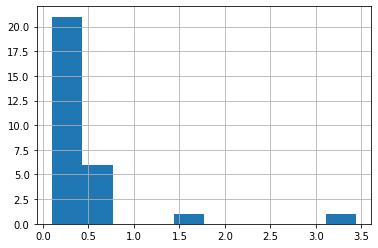

In [330]:
"""
ValidityLeft indicates the confidence level that the left eye has been correctly identified. The values range from 0
(high confidence) to 4 (eye not found). ValidityRight does the same for the right eye. 

As can be seen in the histograms for ValidityLeft and ValidityRight, most participants have average validities below 
0.5 for their left and right eyes. Participant 19's validity is an extreme outlier at around 3.5, and therefore 
that participant's data cannot be used. Participant 16 probably shouldn't be used either because their validity 
was around 1.76. Participants 15, 3, and 26 are at 0.7, 0.6, and 0.6, respectively. They're probably on the margin 
in terms of usability. Participants 4, 18, and 5 have the best (lowest) validities. 
"""

# show the average validities for the left eye for each participant, optionally run the histogram command

total_data.groupby(['ParticipantName']).ValidityLeft.mean().sort_values(ascending=False).hist()
left_validity = total_data.groupby(['ParticipantName']).ValidityLeft.mean().sort_values(ascending=False)
left_validity

ParticipantName
P19    3.306102
P16    1.760493
P15    0.662615
P03    0.600949
P26    0.584915
P23    0.539445
P14    0.478653
P13    0.419186
P09    0.413557
P01    0.363031
P07    0.344609
P10    0.308257
P22    0.307235
P29    0.302078
P25    0.281534
P20    0.256810
P02    0.229921
P17    0.224083
P28    0.204327
P11    0.201523
P27    0.195478
P12    0.184317
P08    0.150770
P21    0.141716
P06    0.136025
P24    0.129820
P04    0.124850
P05    0.122289
P18    0.084987
Name: ValidityRight, dtype: float64

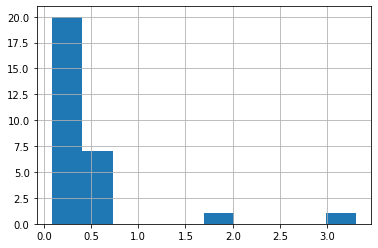

In [331]:
# show the average validities for the right eye for each participant, optionally run the histogram command

total_data.groupby(['ParticipantName']).ValidityRight.mean().sort_values(ascending=False).hist()
right_validity = total_data.groupby(['ParticipantName']).ValidityRight.mean().sort_values(ascending=False)
right_validity

ParticipantName
P19    0.135918
P15    0.056686
P06    0.039440
P13    0.024731
P18    0.021938
P25    0.017117
P26    0.016191
P03    0.014585
P16    0.005785
P17    0.003247
P07    0.003136
P11    0.001847
P14   -0.000210
P28   -0.002782
P24   -0.003279
P02   -0.003371
P22   -0.003431
P05   -0.005356
P08   -0.006047
P29   -0.008930
P10   -0.009325
P21   -0.009490
P01   -0.010741
P09   -0.019812
P04   -0.027160
P20   -0.033588
P12   -0.036817
P27   -0.037986
P23   -0.080252
dtype: float64

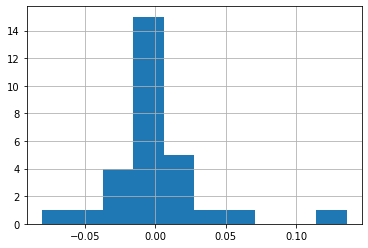

In [332]:
# This shows how much better the validity for left eye was than for the right eye. There's only a big difference
# for participant 23 and participant 15, it may be better to only use their right eye and left eye data, respectively.

diff_validity = left_validity - right_validity

diff_validity.hist()
diff_validity.sort_values(ascending=False)

In [333]:
# display the start and end for each word for each participant
"""
If the difference in time for a media between the start and end is very short, that means it was skipped by and we 
should delete it, however we will need to double check the result of those deletions with the recording sheet to make 
sure that we didn't delete times when the participant solved the anagram very quickly. Note that RecordingTimestamp 
is measured in milliseconds and starts at 0 for each participants and ends at however long the recording was for 
that participant. Divide by 60,000 to convert to minutes.
Note that the ParticipantName and MediaName columns are in some kind of alphabetical order here.
"""
# There's a bug here, which is that the '123456' and the 'black_break_image' show up more than once, so the time 
# between the min and max for them will be extremely large
total_data.groupby(['ParticipantName', 'MediaName']).RecordingTimestamp.agg([min, max])

min       max
ParticipantName MediaName                            
P01             123456                878.0  929821.0
                AETCJK             893565.0  894031.0
                ARDIEM             196733.0  413205.0
                ASONLG             890567.0  892016.0
                IUJONR             413305.0  454791.0
...                                     ...       ...
P29             REABYT             425437.0  590781.0
                RNOBW               79011.0   83708.0
                TDMSOE             621124.0  716670.0
                UMKPAE             716737.0  718885.0
                black_break_image   89786.0  209731.0

[430 rows x 2 columns]

18.119483333333335

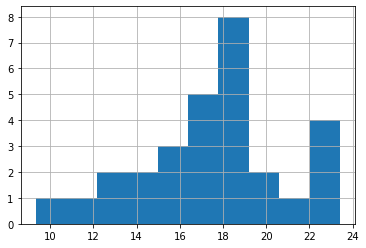

In [334]:
"""
Find the total recording time for each participant (in minutes). The median is 18 minutes. The total time of the 
experiment was 30 minutes but for some it took a longer or shorter amount of time to do the calibration/read the 
prompt. Also near the end we promised to let participants out after 25 minutes to incentivize them to come, plus it 
seemed as though 30 minutes was too long and the quality of data would go down.
"""

# (divide by 60000 to convert from milliseconds to minutes)
total_recording_time = total_data.groupby(['ParticipantName']).RecordingTimestamp.max().map(lambda x: x / 60000)

total_recording_time.hist()
total_recording_time.median()

In [335]:
"""
The coordinates for the five and six letter words are provided. They're listed as [x, y] where x and and y are both
measured from the top left corner of the screen. They coordinates are provided in clockwise direction from left middle
such that they align with the entries in the 'MediaName' column. For example, if the MediaName is 'anagram_PWROE.tiff'
then the coordinate for the letter P is [32, 507], the coordinate for W is [451, 44], R is [1131, 222], etc.
The same thing for the six letter words. Thus, some simple code can be written to convert from MediaName to 
the location of the coordinates for each letter in the word.
In fact, we should probably convert the MediaName to just be anagram, so 'anagram_PWROE.tiff' is written as 'PWROE'.
"""
five_letter_coordinates = [[32, 507], [451, 44], [1131, 222], [1132, 793], [450, 971]]
six_letter_coordinates = [[35, 509], [335, 87], [943, 87], [1245, 509], [944, 928], [334, 928]]

# Note that these are the distances between the coordinates, the code for finding them is shown below, just some 
# pythagorean theorem
five_letter_distances = [624.4, 702.9, 571.0, 704.8, 624.5]
six_letter_distances = [517.8, 608.0, 518.9, 515.9, 610.0, 514.7]

# The letters are not equidistant from each other, the way the MATLAB code was written for making the stimuli was so 
# that the angles between the letters would be equal

# Half the distance between adjacent letters tell us the maximum possible radius we can use to call a 'hit'
# on each letter. The minimum half distance for the five-letter-words is 285 and for the six-letter-words is 257.
half_five_letter_distances = [312.2, 351.5, 285.5, 352.4, 312.3]
half_six_letter_distances = [258.9, 304.0, 259.5, 258.0, 305.0, 257.4]

# We might even want to use half of those minimums, which for the five-letter-words is 143 and for the six-letter-
# words is 129. Therefore, any distance less than 143 is a hit for the five-letter-words and any distance less than
# 129 is a hit for the six-letter-words


# total_data.MediaName.unique()
# total_data.ParticipantName.unique()

In [336]:
ROUND = 6


def measure_distances(coordinate_list, round_number=ROUND):
    coordinate_list_copy = []
    for element in coordinate_list:
        coordinate_list_copy.append(element)
    
    coordinate_list_copy.append(coordinate_list_copy[0])
    distances = []
    for i in range(len(coordinate_list_copy) - 1):
        x_d = coordinate_list_copy[i + 1][0] - coordinate_list_copy[i][0]
        y_d = coordinate_list_copy[i + 1][1] - coordinate_list_copy[i][1]

        d = ((x_d ** 2) + (y_d ** 2)) ** 0.5
        distances.append(round(d, round_number))
    return distances


five_letter_distances = measure_distances(five_letter_coordinates)
six_letter_distances = measure_distances(six_letter_coordinates)

half_five_letter_distances = [round(value / 2, 6) for value in five_letter_distances]
half_six_letter_distances = [round(value / 2, 6) for value in six_letter_distances]


print(min(half_five_letter_distances) / 2)
print(min(half_six_letter_distances) / 2)

142.750219
128.686149


In [337]:
# Here you can see that P13 and P14 had the same stimuli, unfortunately.

total_data.groupby('ParticipantName').MediaName.unique()

ParticipantName
P01    [nan, 123456, LEADFW, SCODLE, ARDIEM, IUJONR, ...
P02    [nan, 123456, AFDWLE, CEOLDS, IAMEDR, NOJUIR, ...
P03    [nan, 123456, WFEADL, CSOELD, RAIMED, JIUORN, ...
P04    [nan, 123456, LAEFDW, ELCSDO, DIEMAR, INOJRU, ...
P05    [nan, 12345, CLHKA, ROEPW, BWRNO, TORCU, black...
P06    [nan, 12345, HKCAL, WRPEO, WRNOB, ROTCU, black...
P07    [nan, 12345, LCAKH, ORWPE, ONRWB, ORUCT, black...
P08    [nan, 12345, AKHLC, ORPWE, OWRNB, UORCT, black...
P09    [nan, 12345, CKAHL, EWPRO, BOWRN, OTCUR, black...
P10    [nan, 12345, CALHK, PWROE, NBWRO, CTUOR, black...
P11    [nan, 12345, HLCAK, PRWOE, BNRWO, CUTOR, black...
P12    [nan, 12345, KHLCA, RWOEP, RWBON, ROTUC, black...
P13    [nan, 12345, KAHLC, OEPWR, ORWBN, OUTCR, black...
P14    [nan, 12345, KAHLC, OEPWR, ORWBN, OUTCR, black...
P15    [nan, 12345, LHAKC, OEWPR, WRONB, UCTOR, black...
P16    [nan, 12345, KCLHA, RWPEO, RJONUI, UTCRO, blac...
P17    [nan, 12345, LHKCA, WROEP, OBWRN, TORUC, black...
P18    [nan, 12

In [338]:
# Drop all entries from the participants whose eyes could not be identified well by the eye trackier (particpants 16
# and 19)

total_data = total_data[(total_data.ParticipantName != 'P19') & (total_data.ParticipantName != 'P16')]

In [339]:
# Now we can see that 'P19' and 'P16' are dropped

total_data.ParticipantName.unique()

array(['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P22', nan, 'P17', 'P18',
       'P20', 'P21', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29'],
      dtype=object)

In [340]:
# Replace Nan in MediaName with 'none'

total_data.MediaName = total_data.MediaName.fillna('none')

In [341]:
total_data

,ParticipantName,RecordingDate,MediaName,RecordingTimestamp,FixationIndex,GazeEventType,GazeEventDuration,gen_gazeX,gen_gazeY,GazePointLeftX (ADCSpx),GazePointLeftY (ADCSpx),GazePointRightX (ADCSpx),GazePointRightY (ADCSpx),FixationPointX (MCSpx),FixationPointY (MCSpx),GazePointX (MCSpx),GazePointY (MCSpx),DistanceLeft,DistanceRight,EyePosLeftX (ADCSmm),EyePosLeftY (ADCSmm),EyePosLeftZ (ADCSmm),EyePosRightX (ADCSmm),EyePosRightY (ADCSmm),EyePosRightZ (ADCSmm),ValidityLeft,ValidityRight,PupilLeft,PupilRight,SaccadeIndex
0,P01,11/4/2019,none,12.0,NaN,Unclassified,8.0,645.0,448.0,578.0,435.0,712.0,462.0,NaN,NaN,NaN,NaN,596.49,596.49,146.82,133.73,589.20,200.72,130.35,591.33,0.0,0.0,5.49,5.38,NaN
1,P01,11/4/2019,none,29.0,1.0,Fixation,733.0,644.0,452.0,579.0,437.0,710.0,467.0,NaN,NaN,NaN,NaN,596.52,596.52,146.81,133.75,589.23,200.71,130.36,591.30,0.0,0.0,5.49,5.38,NaN
2,P01,11/4/2019,none,46.0,1.0,Fixation,733.0,644.0,451.0,575.0,438.0,713.0,464.0,NaN,NaN,NaN,NaN,596.49,596.49,146.81,133.75,589.19,200.70,130.34,591.16,0.0,0.0,5.48,5.39,NaN
3,P01,11/4/2019,none,62.0,1.0,Fixation,733.0,646.0,451.0,579.0,440.0,713.0,463.0,NaN,NaN,NaN,NaN,596.42,596.42,146.82,133.73,589.12,200.70,130.32,591.12,0.0,0.0,5.49,5.38,NaN
4,P01,11/4/2019,none,79.0,1.0,Fixation,733.0,645.0,452.0,580.0,441.0,711.0,464.0,NaN,NaN,NaN,NaN,596.25,596.25,146.84,133.68,588.97,200.72,130.33,591.22,0.0,0.0,5.47,5.38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888472,P29,12/6/2019,none,730993.0,NaN,Saccade,50.0,907.0,95.0,881.0,83.0,933.0,108.0,NaN,NaN,NaN,NaN,652.29,652.29,145.54,148.64,642.97,206.17,152.90,642.30,0.0,0.0,4.33,3.97,2294.0
1888473,P29,12/6/2019,none,731010.0,NaN,Saccade,50.0,1132.0,43.0,1124.0,25.0,1141.0,62.0,NaN,NaN,NaN,NaN,652.68,652.68,146.06,148.76,643.35,206.63,153.07,642.97,0.0,0.0,4.30,3.97,2294.0
1888474,P29,12/6/2019,none,731026.0,NaN,Unclassified,25.0,1155.0,42.0,1153.0,26.0,1157.0,59.0,NaN,NaN,NaN,NaN,652.26,652.26,146.11,148.62,642.96,206.69,152.96,642.69,0.0,0.0,4.37,4.00,NaN
1888475,P29,12/6/2019,none,731043.0,NaN,Unclassified,25.0,1150.0,46.0,1153.0,31.0,1148.0,62.0,NaN,NaN,NaN,NaN,652.24,652.24,146.10,148.61,642.95,206.71,152.94,642.71,0.0,0.0,4.35,4.00,NaN


In [342]:
# reduce the size of total_data so things go a bit faster 

# total_data = total_data.loc[1600000:]
# total_data

In [343]:
# Set the five_d_1 column to be length of a media name: '4' if the MediaName is none, '5' if the MediaName is 12345 or
# a five letter word, '6' if the MediaName is 123456 or a six letter word, and '17' if the MediaName is 
# 'black_break_image'. This way, we avoid having to use apply(), which I've tried using and it is way way too slow.
total_data['five_d_1'] = total_data.MediaName.str.len().astype(str) + '<' + total_data.gen_gazeX.astype(str) + '<' + total_data.gen_gazeY.astype(str)

# copy the string in five_d_1 to all the other five_d's 
total_data['five_d_2'] = total_data['five_d_3'] = total_data['five_d_4'] = total_data['five_d_5'] = total_data.five_d_1


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [344]:
# do the same for six_d_1 

total_data['six_d_1'] = total_data.MediaName.str.len().astype(str) + '<' + total_data.gen_gazeX.astype(str) + '<' + total_data.gen_gazeY.astype(str)
total_data['six_d_2'] = total_data['six_d_3'] = total_data['six_d_4'] = total_data['six_d_5'] = total_data['six_d_6'] = total_data.six_d_1


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [345]:
five_letter_coordinates = [[32, 507], [451, 44], [1131, 222], [1132, 793], [450, 971]]

distance_number = 1

def get_distance_5(entry):
    entry = entry.split('<')
    # if the MediaName length is 4, 6, or 17, return NaN
    # Yes I know this is badly written but when I used 'or' the whole notebook crashed and that happened a few times 
    # so I'm playing it safe. 
    if entry[0] == '4':
        return float('nan')
    elif entry[0] == '6':
        return float('nan')
    elif entry[0] == '17':
        return float('nan')
    
    # Else, return the distance betwen the coordinate of the gaze and the letter in question
    else:
        x1 = float(entry[1])
        y1 = float(entry[2])
        
        x0 = five_letter_coordinates[distance_number - 1][0]
        y0 = five_letter_coordinates[distance_number - 1][1]
        
        xd_sq = (x1 - x0) ** 2
        yd_sq = (y1 - y0) ** 2
        
        d = (xd_sq + yd_sq) ** 0.5
        
        return d


In [346]:
distance_number = 1
total_data.five_d_1 = total_data.five_d_1.map(get_distance_5)

distance_number = 2
total_data.five_d_2 = total_data.five_d_2.map(get_distance_5)

distance_number = 3
total_data.five_d_3 = total_data.five_d_3.map(get_distance_5)

distance_number = 4
total_data.five_d_4 = total_data.five_d_4.map(get_distance_5)

distance_number = 5
total_data.five_d_5 = total_data.five_d_5.map(get_distance_5)

In [347]:
six_letter_coordinates = [[35, 509], [335, 87], [943, 87], [1245, 509], [944, 928], [334, 928]]

distance_number = 1

def get_distance_6(entry):
    entry = entry.split('<')
    # if the MediaName length is 4, 5, or 17, return NaN
    if entry[0] == '4':
        return float('nan')
    elif entry[0] == '5':
        return float('nan')
    elif entry[0] == '17':
        return float('nan')
    
    # Else, return the distance betwen the coordinate of the gaze and the letter in question
    else:
        x1 = float(entry[1])
        y1 = float(entry[2])
        
        x0 = six_letter_coordinates[distance_number - 1][0]
        y0 = six_letter_coordinates[distance_number - 1][1]
        
        xd_sq = (x1 - x0) ** 2
        yd_sq = (y1 - y0) ** 2
        
        d = (xd_sq + yd_sq) ** 0.5
        
        return d


In [348]:
distance_number = 1
total_data.six_d_1 = total_data.six_d_1.map(get_distance_6)

distance_number = 2
total_data.six_d_2 = total_data.six_d_2.map(get_distance_6)

distance_number = 3
total_data.six_d_3 = total_data.six_d_3.map(get_distance_6)

distance_number = 4
total_data.six_d_4 = total_data.six_d_4.map(get_distance_6)

distance_number = 5
total_data.six_d_5 = total_data.six_d_5.map(get_distance_6)

distance_number = 6
total_data.six_d_6 = total_data.six_d_6.map(get_distance_6)

In [355]:
total_data

,ParticipantName,RecordingDate,MediaName,RecordingTimestamp,FixationIndex,GazeEventType,GazeEventDuration,gen_gazeX,gen_gazeY,GazePointLeftX (ADCSpx),GazePointLeftY (ADCSpx),GazePointRightX (ADCSpx),GazePointRightY (ADCSpx),FixationPointX (MCSpx),FixationPointY (MCSpx),GazePointX (MCSpx),GazePointY (MCSpx),DistanceLeft,DistanceRight,EyePosLeftX (ADCSmm),EyePosLeftY (ADCSmm),EyePosLeftZ (ADCSmm),EyePosRightX (ADCSmm),EyePosRightY (ADCSmm),EyePosRightZ (ADCSmm),ValidityLeft,ValidityRight,PupilLeft,PupilRight,SaccadeIndex,five_d_1,five_d_2,five_d_3,five_d_4,five_d_5,six_d_1,six_d_2,six_d_3,six_d_4,six_d_5,six_d_6
0,P01,11/4/2019,none,12.0,NaN,Unclassified,8.0,645.0,448.0,578.0,435.0,712.0,462.0,NaN,NaN,NaN,NaN,596.49,596.49,146.82,133.73,589.20,200.72,130.35,591.33,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P01,11/4/2019,none,29.0,1.0,Fixation,733.0,644.0,452.0,579.0,437.0,710.0,467.0,NaN,NaN,NaN,NaN,596.52,596.52,146.81,133.75,589.23,200.71,130.36,591.30,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P01,11/4/2019,none,46.0,1.0,Fixation,733.0,644.0,451.0,575.0,438.0,713.0,464.0,NaN,NaN,NaN,NaN,596.49,596.49,146.81,133.75,589.19,200.70,130.34,591.16,0.0,0.0,5.48,5.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P01,11/4/2019,none,62.0,1.0,Fixation,733.0,646.0,451.0,579.0,440.0,713.0,463.0,NaN,NaN,NaN,NaN,596.42,596.42,146.82,133.73,589.12,200.70,130.32,591.12,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P01,11/4/2019,none,79.0,1.0,Fixation,733.0,645.0,452.0,580.0,441.0,711.0,464.0,NaN,NaN,NaN,NaN,596.25,596.25,146.84,133.68,588.97,200.72,130.33,591.22,0.0,0.0,5.47,5.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888472,P29,12/6/2019,none,730993.0,NaN,Saccade,50.0,907.0,95.0,881.0,83.0,933.0,108.0,NaN,NaN,NaN,NaN,652.29,652.29,145.54,148.64,642.97,206.17,152.90,642.30,0.0,0.0,4.33,3.97,2294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888473,P29,12/6/2019,none,731010.0,NaN,Saccade,50.0,1132.0,43.0,1124.0,25.0,1141.0,62.0,NaN,NaN,NaN,NaN,652.68,652.68,146.06,148.76,643.35,206.63,153.07,642.97,0.0,0.0,4.30,3.97,2294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888474,P29,12/6/2019,none,731026.0,NaN,Unclassified,25.0,1155.0,42.0,1153.0,26.0,1157.0,59.0,NaN,NaN,NaN,NaN,652.26,652.26,146.11,148.62,642.96,206.69,152.96,642.69,0.0,0.0,4.37,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888475,P29,12/6/2019,none,731043.0,NaN,Unclassified,25.0,1150.0,46.0,1153.0,31.0,1148.0,62.0,NaN,NaN,NaN,NaN,652.24,652.24,146.10,148.61,642.95,206.71,152.94,642.71,0.0,0.0,4.35,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [397]:
hit_five_num = total_data.MediaName + '<' + total_data.five_d_1.astype(str) + '<' + total_data.five_d_2.astype(str) + '<' + total_data.five_d_3.astype(str) + '<' + total_data.five_d_4.astype(str) + '<' + total_data.five_d_5.astype(str)

In [417]:
hit_word_length = 5


def convert_hit(hit_entry):
    if hit_word_length == 5:
        min_hit_distance = 143
    elif hit_word_length == 6:
        min_hit_distance = 129
    
    
    
    hit_entry_list = hit_entry.split('<')
    
    
    
    if len(hit_entry_list[0]) != hit_word_length:
        return float('nan')
    else: 
        hit_entry_list_nums_only = hit_entry_list[1:]
        hit_entry_list_nums_only_float = [float(value) for value in hit_entry_list_nums_only]
        min_distance = min(hit_entry_list_nums_only_float)
        min_number_clockwise = hit_entry_list_nums_only_float.index(min_distance) + 1
        
        
        if min_distance <= min_hit_distance:
            # if we want the distance then run this instead:
            # return min_distance
            
            return min_number_clockwise
        else:
            return float('nan')
        



hit_five_num1 = hit_five_num.map(convert_hit)

In [418]:
hit_five_num1.unique()

array([nan,  2.,  3.,  4.,  5.,  1.])

In [419]:
hit_five_num1

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1888472   NaN
1888473   NaN
1888474   NaN
1888475   NaN
1888476   NaN
Length: 1726114, dtype: float64

In [416]:
list0 = ['hi', '20', '2', '14', '1']
list1 = list0[1:]
print(list1)
list2 = [float(value) for value in list1]
print(type(list2[0]))
min_num = min(list2)
print(min_num)
print(list2.index(min_num) + 1)

['20', '2', '14', '1']
<class 'float'>
1.0
4


In [349]:
total_data.groupby('ParticipantName').MediaName.unique()


ParticipantName
P01    [none, 123456, LEADFW, SCODLE, ARDIEM, IUJONR,...
P02    [none, 123456, AFDWLE, CEOLDS, IAMEDR, NOJUIR,...
P03    [none, 123456, WFEADL, CSOELD, RAIMED, JIUORN,...
P04    [none, 123456, LAEFDW, ELCSDO, DIEMAR, INOJRU,...
P05    [none, 12345, CLHKA, ROEPW, BWRNO, TORCU, blac...
P06    [none, 12345, HKCAL, WRPEO, WRNOB, ROTCU, blac...
P07    [none, 12345, LCAKH, ORWPE, ONRWB, ORUCT, blac...
P08    [none, 12345, AKHLC, ORPWE, OWRNB, UORCT, blac...
P09    [none, 12345, CKAHL, EWPRO, BOWRN, OTCUR, blac...
P10    [none, 12345, CALHK, PWROE, NBWRO, CTUOR, blac...
P11    [none, 12345, HLCAK, PRWOE, BNRWO, CUTOR, blac...
P12    [none, 12345, KHLCA, RWOEP, RWBON, ROTUC, blac...
P13    [none, 12345, KAHLC, OEPWR, ORWBN, OUTCR, blac...
P14    [none, 12345, KAHLC, OEPWR, ORWBN, OUTCR, blac...
P15    [none, 12345, LHAKC, OEWPR, WRONB, UCTOR, blac...
P17    [none, 12345, LHKCA, WROEP, OBWRN, TORUC, blac...
P18    [none, 12345, CLHAK, WPROE, WBONR, TCROU, blac...
P20    [none, 1

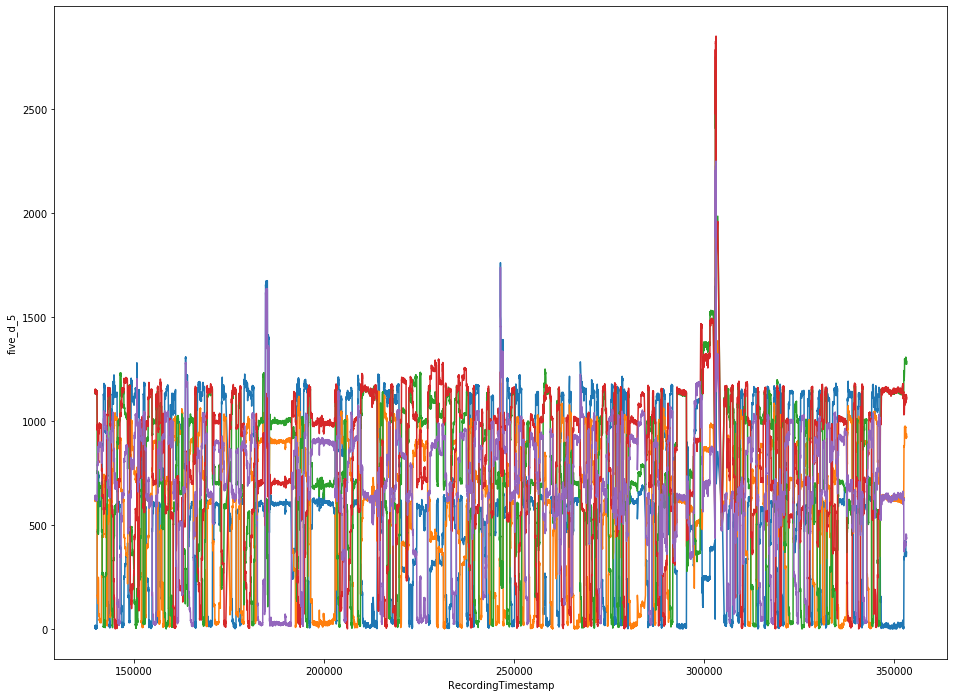

In [357]:

plt.figure(figsize=(16,12))
# total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'AKCLH'].\
# plot(x='RecordingTimestamp', y=['five_d_1', 'five_d_2', 'five_d_3', 'five_d_4', 'five_d_5'])

y_data = total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'OEPRW']
# plt.ylim(top=143)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_1)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_2)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_3)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_4)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_5)





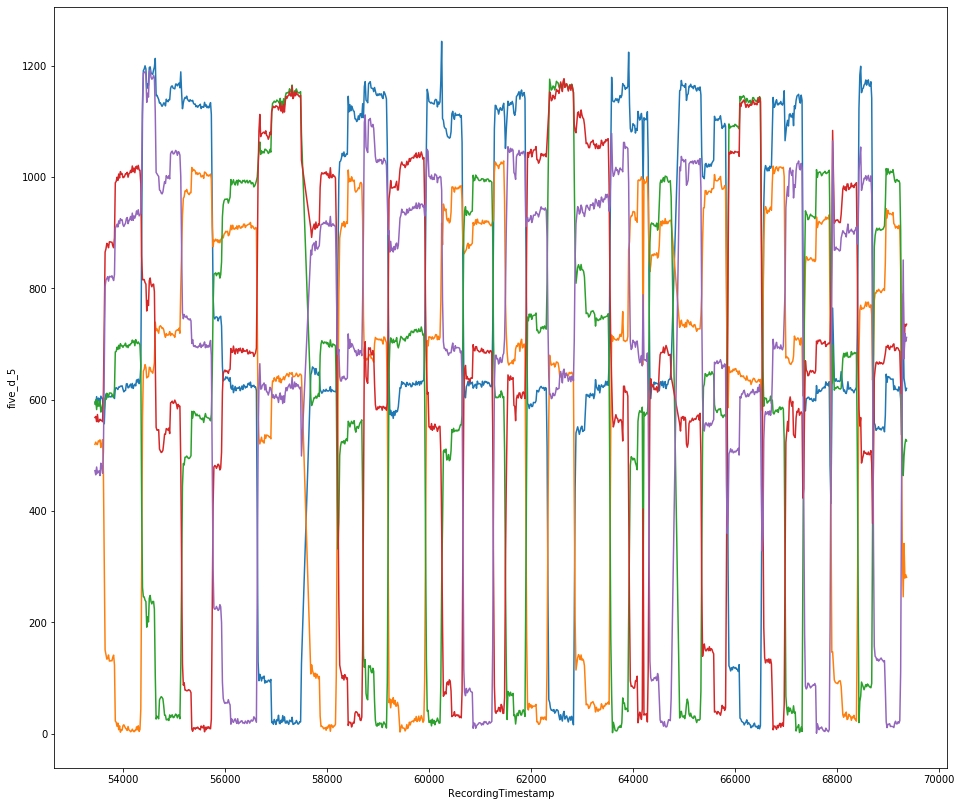

In [351]:

plt.figure(figsize=(16,14))
# total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'AKCLH'].\
# plot(x='RecordingTimestamp', y=['five_d_1', 'five_d_2', 'five_d_3', 'five_d_4', 'five_d_5'])

y_data = total_data.loc[total_data.ParticipantName == 'P25'].loc[total_data.MediaName == 'HLACK']
# plt.ylim(top=143)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_1)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_2)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_3)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_4)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_5)





In [ ]:
"""
The next step is probably to get a rudimentary generation of the letter sequence data. We can refine it later to 
reflect things like fixation, etc. 

Then we would have a pandas sheet that does not go by timestamp, rather it be ~ 400 rows and just be the MediaName
for each participant. One of the columns would have a number sequence from middle left going clockwise starting with 
the number 1. Which, based on the order of the letters for the word, could be converted to 1-5 or 1-6 in terms of the 
order of the letter in the word, 0-1 for consonant or vowel, or could be letters just representing the letter they're
looking at. 
We would fill in this pandas sheet with all the information about the participant, listed on the github README:
1 or 0 for correct or incorrect, list of guesses, experience with anagrams, etc. We could even add male/female. 

"""

In [ ]:

plt.figure(figsize=(16,14))
# total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'AKCLH'].\
# plot(x='RecordingTimestamp', y=['five_d_1', 'five_d_2', 'five_d_3', 'five_d_4', 'five_d_5'])

y_data = total_data.loc[total_data.ParticipantName == 'P25'].loc[total_data.MediaName == 'HLACK']
# plt.ylim(top=143)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_1)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_2)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_3)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_4)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_5)



